In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class Dataset:
  def __init__(self) -> None:
     self.train_dataset=None
     self.validation_dataset=None
     self.test_dataset=None
     self.batch_train_dataset=None
     self.batch_validation_dataset=None
     self.batch_test_dataset=None
     self.num_classes=tfds.builder('colorectal_histology').info.features['label'].num_classes
     self.image_shape=tfds.builder('colorectal_histology').info.features['image'].shape

  def load_data(self, split=['train[:70%]', 'train[70%:85%]', 'train[85%:]']):
    self.train_dataset, self.validation_dataset, self.test_dataset = tfds.load('colorectal_histology', split=split, as_supervised=True)
    print('load data successful')

  def plot_some_datas(self, data_type='train', n=5):
    def plot_data(dataset):
      plt.subplots(figsize=(15,15))
      n_col=3
      n_line=math.ceil(n/3)
      for i, data in enumerate(dataset):
        image=data[0].numpy()
        label=data[1].numpy()
        plt.subplot(n_line,n_col,i+1)
        plt.imshow(image)
        plt.title('Class '+str(label))
      plt.show()
      
    if data_type=='train':
      dataset=self.train_dataset.take(n)
      plot_data(dataset)
      print(n,' samples of the training dataset')
    elif data_type=='val':
      dataset=self.validation_dataset.take(n)
      plot_data(dataset)
      print(n,' samples of the validation dataset')
    else :
      dataset=self.test_dataset.take(n)
      plot_data(dataset)
      print(n, 'samples of the test dataset')

  def get_preprocess_data(self, target_shape=None, BATCH_SIZE=32, BUFFER_SIZE=1000):
    def preprocess_data(images, labels):
      images = images/255
      if target_shape is not None :
        images = tf.image.resize(images, (target_shape, target_shape))
      return images, labels

    self.train_dataset.shuffle(1024)
    self.batch_train_dataset = self.train_dataset.map(preprocess_data).cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    self.validation_dataset.shuffle(1024)
    self.batch_validation_dataset = self.validation_dataset.map(preprocess_data).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

    self.test_dataset.shuffle(1024)
    self.batch_test_dataset = self.test_dataset.map(preprocess_data).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

    if target_shape is not None :
      self.image_shape = (target_shape, target_shape, 3)
    else:
      self.image_shape = (150,150,3)
    
    print('preprocess data successful')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteBAYF9J/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
load data successful


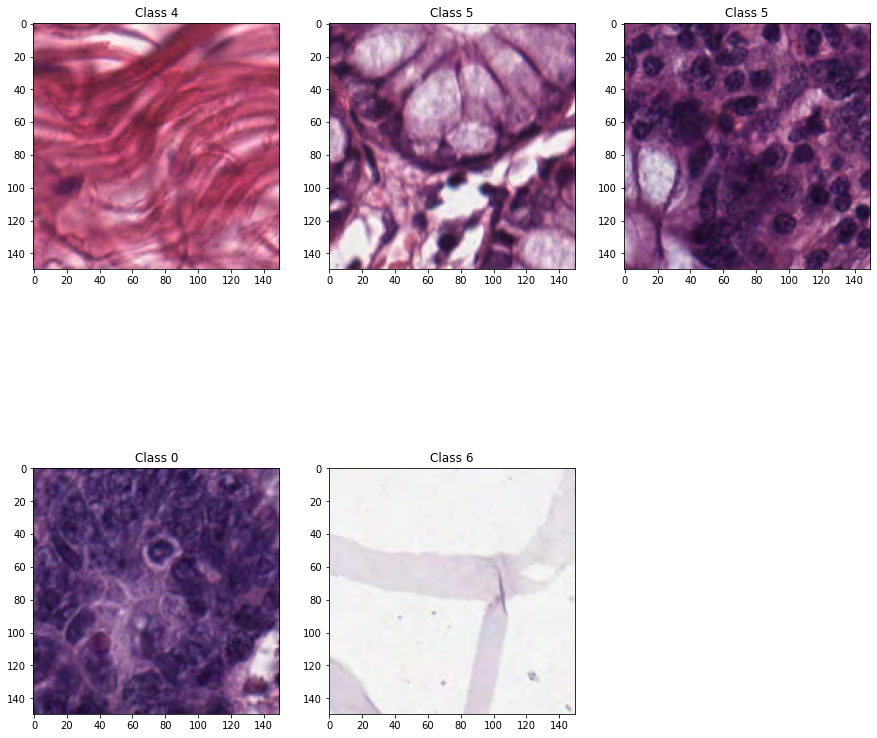

5  samples of the training dataset


In [3]:
split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]']
dataset = Dataset()
dataset.load_data(split)
dataset.plot_some_datas()

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-12-18 13:26:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   137MB/s    in 0.6s    

2022-12-18 13:26:48 (137 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)


pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
  layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
from tensorflow.keras import Model
NB_DENSE = 2
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
for dense in range(NB_DENSE):
  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(512, activation='relu')(x)
  # Add a dropout rate of 0.5
  x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(dataset.num_classes, activation='softmax')(x)           

# Append the dense network to the base model
pretrain_model = Model(pre_trained_model.input, x) 


pretrain_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
pretrain_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
dataset.get_preprocess_data()
pretrain_model.fit(dataset.batch_train_dataset, epochs=20, validation_data=dataset.batch_validation_dataset)

preprocess data successful
Epoch 1/20
110/110 [==============================] - 18s 62ms/step - loss: 1.3974 - accuracy: 0.6011 - val_loss: 0.6458 - val_accuracy: 0.8147
Epoch 2/20
110/110 [==============================] - 4s 37ms/step - loss: 0.7578 - accuracy: 0.7631 - val_loss: 0.5677 - val_accuracy: 0.8427
Epoch 3/20
110/110 [==============================] - 4s 37ms/step - loss: 0.5522 - accuracy: 0.8123 - val_loss: 0.5244 - val_accuracy: 0.8427
Epoch 4/20
110/110 [==============================] - 4s 37ms/step - loss: 0.5387 - accuracy: 0.8200 - val_loss: 0.4192 - val_accuracy: 0.8813
Epoch 5/20
110/110 [==============================] - 4s 37ms/step - loss: 0.4388 - accuracy: 0.8483 - val_loss: 0.4346 - val_accuracy: 0.8813
Epoch 6/20
110/110 [==============================] - 4s 37ms/step - loss: 0.3872 - accuracy: 0.8743 - val_loss: 0.4197 - val_accuracy: 0.8760
Epoch 7/20
110/110 [==============================] - 4s 37ms/step - loss: 0.3442 - accuracy: 0.8846 - val_loss: 0